# Check npx32 traces

author: steeve.laquitaine@epfl.ch  
date: 2023.10.11
last modified: 2023.10.11  
status:  OK
display-status: up-to-date  
regression: None  

Kilosort3 operations:
- read raw traces `<- we inspect here`
- pad traces
- high-bass filter + detrending 
- whitening `<- we inspect here`

### Setup

setup `npx_10_384ch_unit_classes`

Trace plots are saved at different steps of preprocessing in KS3 matlab code in `/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/controls/sorters/Kilosort3_to_check_traces/preProcess/preprocessDataSub.m`

In [46]:
%load_ext autoreload
%autoreload 2

import os
import scipy
from matplotlib import pyplot as plt
import numpy as np

# move to project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023/"
os.chdir(PROJ_PATH)
from src.nodes.dataeng.silico import probe_wiring, recording
from src.nodes.utils import get_config
from src.nodes.prepro import preprocess

# SETUP PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_10_01" # disconnected 
data_conf_32, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
NPX32_BINARY_FILE = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/controls/sorters/Kilosort3_to_check_traces/KS3_output/recording.dat"
RAW_TRACE_IN_KS3_PATH = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/controls/sorters/Kilosort3_to_check_traces/KS3_output/raw_trace_first_batch.mat"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-10-12 16:51:50,787 - root - utils.py - get_config - INFO - Reading experiment config.
2023-10-12 16:51:50,801 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Load raw & preprocessed traces read by KS3

A batch size is 32 electrodes by 65792 timepoints.

To save the traces read in KS3 for inspection, Run in terminal: 
```bash
bash /gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023/src/pipes/controls/check_traces_in_ks3.sh
```

### Plot raw traces

Plot figure from Trautmann et al., 2023

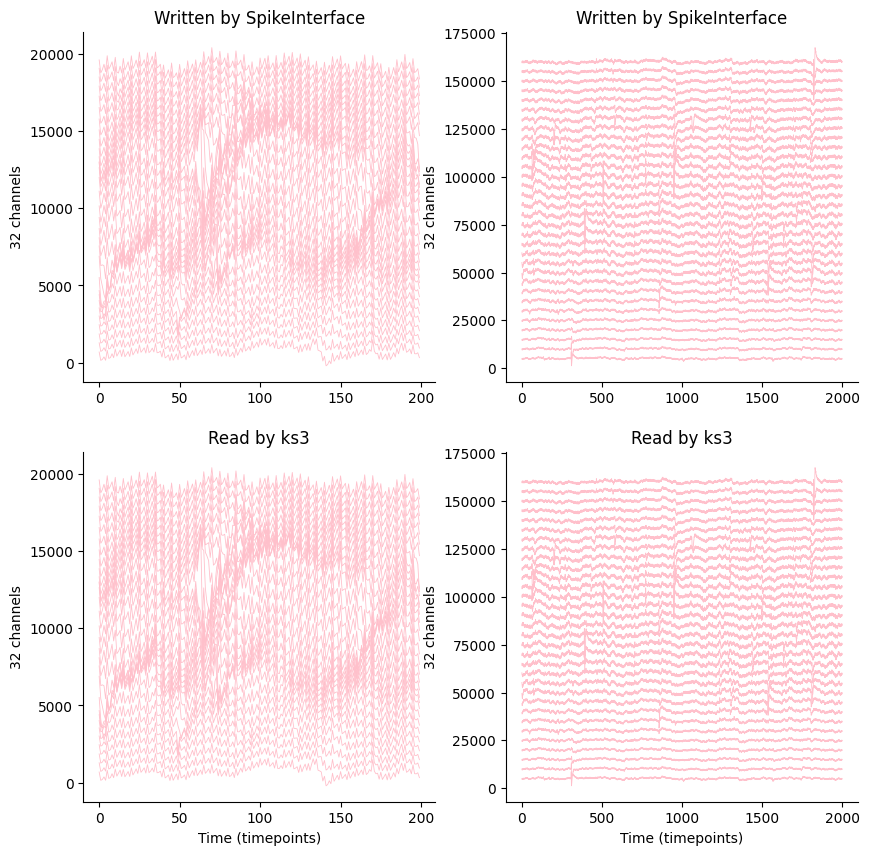

In [50]:
# plot 32 contacts x 5 ms (like Trautmann et al 2023)
sampfreq = 10000    # Hz
duration = 20       # in ms
n_timepoints = int(duration*sampfreq/1000)
Y_STEP = 600
LINEWIDTH = 0.6

# WRITTEN BY SPIKEINTERFACE
Recording = recording.load(data_conf_32);
resc_traces = Recording.get_traces();

# plot - short period
fig, ax = plt.subplots(2,2, figsize=(10,10))
pos_up = 0
for contact_i in np.arange(0,32,1):
    pos_up += Y_STEP
    ax[0,0].plot(resc_traces[:n_timepoints, contact_i] + pos_up, color="pink", linewidth=LINEWIDTH);
ax[0,0].set_title("Written by SpikeInterface");
ax[0,0].set_ylabel("32 channels");
ax[0,0].spines[['right', 'top']].set_visible(False)

# longer period
duration = 200       # in ms
n_timepoints = int(duration*sampfreq/1000)
pos_up = 0
Y_STEP = 5000
for contact_i in np.arange(0,32,1):
    pos_up += Y_STEP
    ax[0,1].plot(resc_traces[:n_timepoints, contact_i] + pos_up, color="pink", linewidth=LINEWIDTH);
ax[0,1].set_title("Written by SpikeInterface");
ax[0,1].set_ylabel("32 channels");
ax[0,1].spines[['right', 'top']].set_visible(False)


# READ BY KS3
# short period
raw_trace_first = scipy.io.loadmat(RAW_TRACE_IN_KS3_PATH)
pos_up = 0
duration = 20       # in ms
n_timepoints = int(duration*sampfreq/1000)
Y_STEP = 600
for contact_i in np.arange(0,32,1):
    pos_up += Y_STEP
    ax[1,0].plot(raw_trace_first["buff"][contact_i, :n_timepoints] + pos_up, color="pink", linewidth=LINEWIDTH)
ax[1,0].set_ylabel("32 channels");
ax[1,0].set_xlabel("Time (timepoints)");
ax[1,0].set_title("Read by ks3");
ax[1,0].spines[['right', 'top']].set_visible(False)


# long period
pos_up = 0
duration = 200       # in ms
n_timepoints = int(duration*sampfreq/1000)
Y_STEP = 5000
for contact_i in np.arange(0,32,1):
    pos_up += Y_STEP
    ax[1,1].plot(raw_trace_first["buff"][contact_i, :n_timepoints] + pos_up, color="pink", linewidth=LINEWIDTH)
ax[1,1].set_ylabel("32 channels");
ax[1,1].set_xlabel("Time (timepoints)");
ax[1,1].set_title("Read by ks3");
ax[1,1].spines[['right', 'top']].set_visible(False)

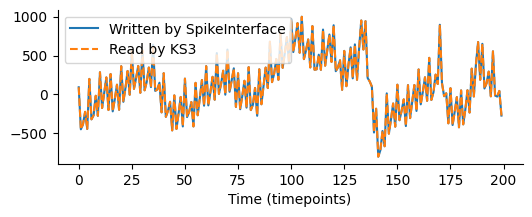

In [23]:
# Zoom in on contact 0
CONTACT = 0
fig, ax = plt.subplots(1,1, figsize=(6,2));
plt.plot(resc_traces[:n_timepoints, CONTACT], label="Written by SpikeInterface");
plt.plot(raw_trace_first["buff"][CONTACT, :n_timepoints], label="Read by KS3", linestyle="--");
ax.set_xlabel("Time (timepoints)");
plt.legend();
ax.spines[['right', 'top']].set_visible(False)

In [42]:
# Check that KS3's read traces are integers of SpikeInterface's output raw trace values.

# read by Kilosort3
print("In Kilosort3:\n", raw_trace_first["buff"][0,:10])

# from SpikeInterface
WiredRecording = probe_wiring.load(data_conf_32)
raw_trace = WiredRecording.get_traces()
print("From SpikeInterface:\n", raw_trace[:10, 0])

In Kilosort3:
 [  92 -448 -384 -223 -443  199 -320 -268  -17 -275]
From SpikeInterface:
 [  92.234375 -448.4453   -384.6875   -223.70312  -443.78906   199.75
 -320.16406  -268.53125   -17.34375  -275.03906 ]


### Plot preprocessed traces

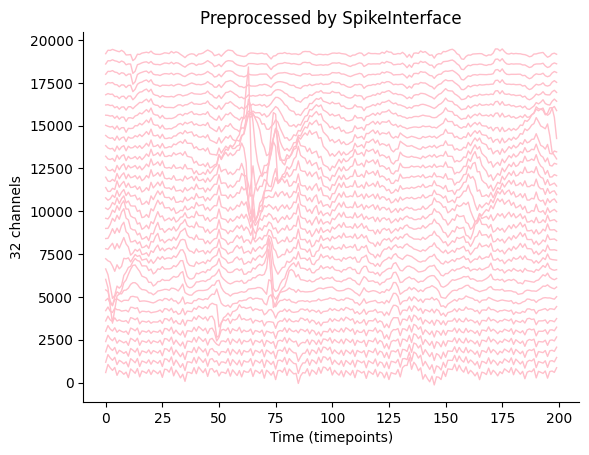

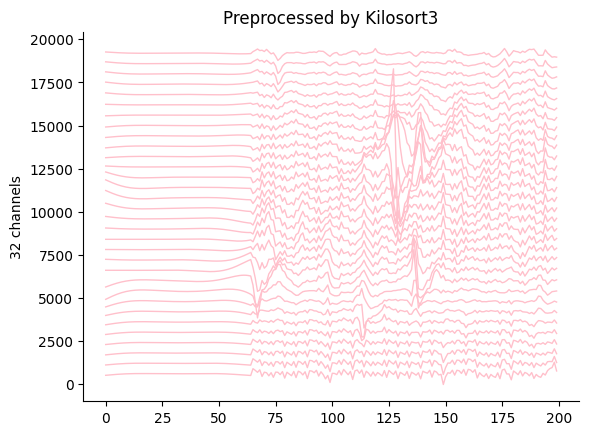

In [53]:
# parameters
sampfreq = 10000    # Hz
duration = 20       # in ms
n_timepoints = int(duration*sampfreq/1000)
Y_STEP = 600
LINEWIDTH = 1


# FROM SPIKEINTERFACE
Recording = preprocess.load(data_conf_32)
traces = Recording.get_traces()
fig, ax = plt.subplots(1,1)
pos_up = 0
for contact_i in np.arange(0, 32,1):
    pos_up += Y_STEP
    ax.plot(traces[:n_timepoints, contact_i] + pos_up, color="pink", linewidth=LINEWIDTH);
ax.set_ylabel("32 channels");
ax.set_title("Preprocessed by SpikeInterface");
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel("Time (timepoints)");


# READ BY KILOSORT3
prep_trace = scipy.io.loadmat("/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/controls/sorters/Kilosort3_to_check_traces/KS3_output/prep_trace_first_batch.mat")
fig, ax = plt.subplots(1,1)
pos_up = 0
for contact_i in np.arange(0,32,1):
    pos_up += Y_STEP
    ax.plot(prep_trace["prep"][:n_timepoints, contact_i] + pos_up, color="pink", linewidth=LINEWIDTH)
ax.set_ylabel("32 channels");
ax.set_title("Preprocessed by Kilosort3");
ax.spines[['right', 'top']].set_visible(False)

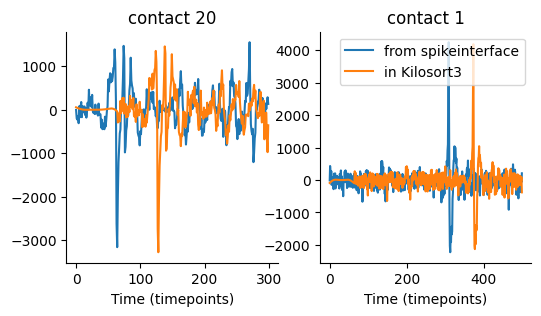

In [41]:
# Zoom in on two contacts

# FROM SPIKEINTERFACE
from src.nodes.prepro import preprocess
Recording = preprocess.load(data_conf_32)
traces = Recording.get_traces()

# IN KILOSORT3
prep_trace = scipy.io.loadmat("/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/controls/sorters/Kilosort3_to_check_traces/KS3_output/prep_trace_first_batch.mat")


# plot 
sampfreq = 10000    # Hz
duration = 40       # in ms
n_timepoints = int(duration*sampfreq/1000)

CONTACT = 20
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(traces[:300,CONTACT], label="from spikeinterface");
axes[0].plot(prep_trace["prep"][:300,CONTACT], label="in Kilosort3");
axes[0].set_title("contact 20");
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].set_xlabel("Time (timepoints)");

CONTACT = 1
axes[1].plot(traces[:500,CONTACT], label="from spikeinterface");
axes[1].plot(prep_trace["prep"][:500,CONTACT], label="in Kilosort3");
axes[1].legend();
axes[1].set_title("contact 1");
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].set_xlabel("Time (timepoints)");

# References

binary recording .dat is created here `spikeinterface.sorters.kilosortbase._setup_recording` with dtype `int16` called from `BaseSorter` in `Class Kilosort3Sorter(KilosortBase, BaseSorter)`

That's where matkab Kilosort3 is actually launched